In [1]:
import os
import json

import numpy as np

from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
from src.jump import Jump
from pso import *

In [3]:
BEG_OF_TIME = '2016-06-01'
END_OF_TIME = '2020-09-30'

PSO_HP = PSOHyperparameters(
    inertia = 0.09,
    inertia_dampening = 0.99,
    cognitive_acceleration = 1.0,
    social_acceleration = 1.0,
)

PSO_POPULATION = 100
PSO_NB_ITER    = 100

In [4]:
def get_asset_returns(asset):
    """
    get complete return time serie for an asset
    """
    returns = []

    prev_date = datetime.strptime(BEG_OF_TIME, '%Y-%m-%d').date() - timedelta(days=1)
    prev_value = 0.0

    for i, values in enumerate(asset["values"]):
        current_date = datetime.strptime(values["date"], '%Y-%m-%d').date()

        nb_days = (current_date - prev_date).days
        diff = (values["return"] - prev_value) / nb_days

        for i in range(nb_days - 1):
            returns.append(prev_value)
        returns.append(values["return"])

        prev_value = values["return"]
        prev_date = current_date

    return returns

In [5]:
def plot_history(history):
    plt.plot(history)
    plt.ylabel('fitness')
    plt.xlabel('iteration')
    plt.title('Evolution of fitnesss')
    plt.show()

In [6]:
def check_constraints(best_particle, nb_funds):
    stock_perc = np.sum(best_particle[nb_funds:])

    nav_ok = np.all(np.logical_and(
        np.logical_or(best_particle == 0, best_particle >= 0.01),
        best_particle < 0.1,
    ))

    nb_assets = np.sum(best_particle >= 0.01)

    print(f"[{'OK' if stock_perc > 0.5 else 'KO'}] Stock %: {stock_perc:.2f}")
    print(f"[{'OK' if nav_ok else 'KO'}] %Nav")
    print(f"[{'OK' if nb_assets > 15 else 'KO'}] Asset count: {nb_assets}")

## Preprocessing

### Load assets & get returns time series

In [8]:
asset_dict = Jump().get_all_assets("assets_cache.json")

keys = list(asset_dict.keys())
assets = list(asset_dict.values())

returns_list = []

for _, asset in asset_dict.items():
    returns = get_asset_returns(asset)
    returns_list.append(returns)

returns_list = np.array(returns_list)

<ipython-input-8-af1960b5ccee>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  returns_list = np.array(returns_list)


### Split funds and stocks

In [9]:
funds_keys = []
stock_keys = []

funds_returns = []
stock_returns = []

funds_real_count = []
funds_price = []
stock_price = []

ref_portfolio = None
our_portfolio = None

for i, (k, v) in enumerate(asset_dict.items()):
    if v["type"] in ("ETF FUND", "FUND", "INDEX"):
        nav = v["values"][0]["values_usd"]["nav"]

        funds_keys.append(k)
        funds_returns.append(returns_list[i])
        funds_price.append(nav)
        funds_real_count.append(1)
        # FIXME funds decimalisation: need to divide price and count

    elif v["type"] in ("STOCK",):
        nav = v["values"][0]["values_usd"]["nav"]

        stock_keys.append(k)
        stock_returns.append(returns_list[i])
        stock_price.append(nav)

    elif v["type"] in ("PORTFOLIO","LOUCHE"):
        ref_portfolio = k, v

    elif v["type"] in ("OUR_PORTFOLIO",):
        our_portfolio = k, v

len(funds_keys), len(stock_keys)

(137, 341)

### Get values for PSO

In [9]:
funds_covariance = np.cov(funds_returns)
stock_covariance = np.cov(stock_returns)

funds_values = np.mean(funds_returns, axis=1)
stock_values = np.mean(stock_returns, axis=1)

## Run PSO for stocks

In [10]:
StockPSO = ParticleSwarmOptimizer(
    population_size=PSO_POPULATION,
    hyperparameters=PSO_HP,
    constraints=PSOConstraints(
        n_var = len(stock_values),
        var_min = 0.02,
        var_max = 0.20,
        min_diff_titles = 8,
    ),
    values=stock_values,
    covariance_matrix=stock_covariance,
)

In [11]:
best_stock_particle, history = StockPSO.run(PSO_NB_ITER)

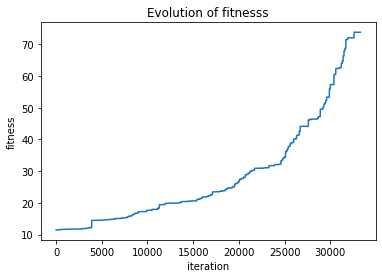

In [12]:
plot_history(history)

## Run PSO for funds

In [13]:
FundsPSO = ParticleSwarmOptimizer(
    population_size=PSO_POPULATION,
    hyperparameters=PSO_HP,
    constraints=PSOConstraints(
        n_var = len(funds_values),
        var_min = 0.02,
        var_max = 0.20,
        min_diff_titles = 8,
    ),
    values=funds_values,
    covariance_matrix=funds_covariance,
)

In [14]:
best_funds_particle, history = FundsPSO.run(PSO_NB_ITER)

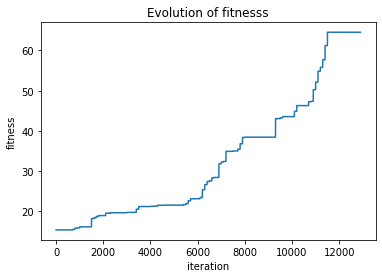

In [15]:
plot_history(history)

# Construct complete portfolio

In [10]:
returns = np.concatenate((funds_returns, stock_returns))
values = np.mean(returns, axis=1)
covariance = np.cov(returns)
prices = np.concatenate((funds_price, stock_price))
real_counts = np.concatenate((funds_real_count, np.ones(len(stock_price))))

best_particle = np.concatenate((best_funds_particle*0.49, best_stock_particle*0.51))

NameError: name 'best_funds_particle' is not defined

#### Check if constraints are respected

In [17]:
check_constraints(best_particle, len(funds_returns))

[OK] Stock %: 0.51
[OK] %Nav
[OK] Asset count: 18


### Compute total fitness

In [18]:
TestPSO = ParticleSwarmOptimizer(
    population_size=0,
    hyperparameters=PSO_HP,
    constraints=PSOConstraints(
        n_var = len(returns),
        var_min = 0.02,
        var_max = 0.20,
        min_diff_titles = 8,
    ),
    values=values,
    covariance_matrix=covariance,
)
TestPSO.fitness(best_particle)

121.00935107416345

# Compute final portfolio

In [19]:
np.max(funds_price), np.max(stock_price)

(344760.82638447924, 7823.328091298724)

In [20]:
def nav_to_count(total, prices, nav):
    return ((total * nav) / prices).astype(np.int32)

def count_to_nav(total, prices, count):
    return (count * prices) / total

def price_error(total, prices, nav):
    diff = nav - count_to_nav(total, prices, nav_to_count(total, prices, nav))
    return np.sum(np.abs(diff))

total_price = 100000

while price_error(total_price, prices, best_particle) > 0.001:
    total_price *= 2

portfolio_titles = nav_to_count(total_price, prices, best_particle).astype(np.int32)
f"{total_price:,}$"

'102,400,000$'

### Let's check if the approximation was successful

In [21]:
final_particle = count_to_nav(total_price, prices, portfolio_titles)
np.max(np.abs(final_particle - best_particle))

0.000548900623291472

In [22]:
TestPSO.fitness(final_particle)

121.06022764270213

In [23]:
check_constraints(final_particle, len(funds_returns))

[OK] Stock %: 0.51
[OK] %Nav
[OK] Asset count: 18


### Compute real portfolio

In [50]:
# funds decimalisation
final_portfolio_counts = portfolio_titles * real_counts

# back to IDs!
final_portfolio = {}
keys = np.concatenate((funds_keys, stock_keys))

for i, v in enumerate(final_portfolio_counts):
    if v == 0:
        continue

    asset = asset_dict[keys[i]]
    date = asset['values'][0]['date']

    final_portfolio.setdefault(date, []).append({
        "asset": {
            "asset": int(keys[i]),
            "quantity": v,
        }
    })

final_portfolio

{'2016-06-01': [{'asset': {'asset': 2149, 'quantity': 28648.0}},
  {'asset': {'asset': 2164, 'quantity': 138625.0}},
  {'asset': {'asset': 1500, 'quantity': 4396.0}},
  {'asset': {'asset': 2189, 'quantity': 14059.0}},
  {'asset': {'asset': 2190, 'quantity': 29066.0}},
  {'asset': {'asset': 2191, 'quantity': 22126.0}},
  {'asset': {'asset': 1612, 'quantity': 9140.0}},
  {'asset': {'asset': 1732, 'quantity': 59.0}},
  {'asset': {'asset': 1745, 'quantity': 32673.0}},
  {'asset': {'asset': 2065, 'quantity': 47244.0}},
  {'asset': {'asset': 1882, 'quantity': 97370.0}},
  {'asset': {'asset': 1922, 'quantity': 986009.0}},
  {'asset': {'asset': 1964, 'quantity': 2309432.0}},
  {'asset': {'asset': 1971, 'quantity': 33315.0}},
  {'asset': {'asset': 2055, 'quantity': 97554.0}},
  {'asset': {'asset': 1571, 'quantity': 35831.0}}],
 '2018-10-22': [{'asset': {'asset': 1867, 'quantity': 20027.0}}],
 '2016-06-02': [{'asset': {'asset': 2024, 'quantity': 576.0}}]}

# Upload portfolio

In [54]:
portfolio_obj = {
    "label": "EPITA_PTF_1",
    "currency": {
        "code": "EUR"
    },
    "type": "front",
    "values": final_portfolio,
}

Jump().update_portfolio(our_portfolio[0], portfolio_obj)

<Response [200]>

### Check sharp ratio

In [12]:
Jump().calculate_ratio([9, 12, 18], [1793])

{
    "_ratio": [
        9,
        12,
        18
    ],
    "_asset": [
        1793
    ],
    "_bench": null,
    "_startDate": "2016-06-01",
    "_endDate": "2020-09-30",
    "_frequency": null
}


<Response [500]>

In [14]:
Jump().get_asset(asset_dict[our_portfolio[0]], our_portfolio[0])

{
    "date": {
        "type": "date",
        "value": "2016-06-01"
    },
    "mean_amount": {
        "type": "double",
        "value": "0"
    },
    "nav": {
        "type": "double",
        "value": "100,145938060623"
    },
    "gross": {
        "type": "double",
        "value": "64265031,22052252"
    },
    "asset": {
        "type": "asset",
        "value": "1820"
    },
    "pl": {
        "type": "double",
        "value": "93650,4685447109"
    },
    "close": {
        "type": "double",
        "value": "64265031,22052252"
    },
    "return": {
        "type": "double",
        "value": "0,001459380606"
    },
    "mean_exposure": {
        "type": "double",
        "value": "0"
    }
}
{
    "date": {
        "type": "date",
        "value": "2016-06-02"
    },
    "mean_amount": {
        "type": "double",
        "value": "0"
    },
    "nav": {
        "type": "double",
        "value": "100,155945873623"
    },
    "gross": {
        "type": "double",
        

[{'date': '2016-06-01',
  'pl': 93650.4685447109,
  'return': 0.001459380606,
  'original_currency': 'EUR',
  'converted': True,
  'values': {'nav': 100.145938060623,
   'gross': 64265031.22052252,
   'close': 0.0},
  'values_usd': {'nav': 111.90307118894013,
   'gross': 71809745.88581187,
   'close': 0.0}},
 {'date': '2016-06-02',
  'pl': 5.7560999996,
  'return': 9.9932291e-05,
  'original_currency': 'EUR',
  'converted': True,
  'values': {'nav': 100.155945873623, 'gross': 57605.76, 'close': 0.0},
  'values_usd': {'nav': 112.0544722434094,
   'gross': 64449.324288,
   'close': 0.0}},
 {'date': '2016-06-08',
  'pl': 23.04,
  'return': 0.000399960004,
  'original_currency': 'EUR',
  'converted': True,
  'values': {'nav': 100.196004246136, 'gross': 57628.8, 'close': 0.0},
  'values_usd': {'nav': 114.00301363125354,
   'gross': 65570.04864,
   'close': 0.0}},
 {'date': '2016-06-09',
  'pl': 0.0,
  'return': 0.0,
  'original_currency': 'EUR',
  'converted': True,
  'values': {'nav': 100.

In [15]:
Jump().get_portfolio(our_portfolio[0])

{'label': 'EPITA_PTF_1',
 'currency': {'code': 'EUR'},
 'type': 'front',
 'values': {'2018-10-22': [{'asset': {'asset': 1867, 'quantity': 20027.0}}],
  '2016-06-01': [{'asset': {'asset': 1922, 'quantity': 986009.0}},
   {'asset': {'asset': 1571, 'quantity': 35831.0}},
   {'asset': {'asset': 1732, 'quantity': 59.0}},
   {'asset': {'asset': 2149, 'quantity': 28648.0}},
   {'asset': {'asset': 2055, 'quantity': 97554.0}},
   {'asset': {'asset': 1612, 'quantity': 9140.0}},
   {'asset': {'asset': 1964, 'quantity': 2309432.0}},
   {'asset': {'asset': 2189, 'quantity': 14059.0}},
   {'asset': {'asset': 2190, 'quantity': 29066.0}},
   {'asset': {'asset': 2191, 'quantity': 22126.0}},
   {'asset': {'asset': 1745, 'quantity': 32673.0}},
   {'asset': {'asset': 2065, 'quantity': 47244.0}},
   {'asset': {'asset': 1971, 'quantity': 33315.0}},
   {'asset': {'asset': 2164, 'quantity': 138625.0}},
   {'asset': {'asset': 1882, 'quantity': 97370.0}},
   {'asset': {'asset': 1500, 'quantity': 4396.0}}],
  '2